# Session 3:  Cloud Computing
## *MsPASS Team*

## Learning Objectives
- Students will learn that object store like AWS S3 can be used like a remote file system
- Students will learn the basic uses of the python package boto3 to retrieve S3 data
- Students will learn how to use MsPASS to manage information stored in S3 files
- Students will learn how to use MsPASS to process data stored on S3 with GeoLab

## Before Running this Notebook
### Launch the database server

As noted in the PrecourseProcessing notebook, an issue we haven't been able to resolve is how to have a private instance of MongoDB launch for each instance of a geolab login.  For that reason you will need to do a shortened version of the commands you used in the PrecourseProcessing notebook.  

Launch a terminal window in GeoLab and enter these commands:
```
cd   #  makes sure you are running this in your home directory
mongod --dbpath ./db --logpath ./logs/mongo_log
```
Note a couple things that can go wrong here:
-  The command will block.  If you want to reuse that terminal window put an & at the end of the mongod launch line.
-  DO NOT exit the terminal window from which you run the mongod command or you will kill the database server.  
-  Each time you reconnect to GeoLab you will need to relaunch the MonogDB server with that  incantation. Be careful you always run the command from the same directory as that way the database files will be written to ~/db and the mongodb log will appear in ~/logs.
-  In all cases it is wise to launch a second Terminal window and verify that worked by typing `ps -A`  You should see a line where the CMD field is "mongod".   If not, contact me by email or slack if you are unable to solve the problem.  The first place to look if you are having a problem is the content of the file ~/logs/mongo_log that will be generated when this command runs.

### Use outside GeoLab
If you are accessing this notebook from github and are not part of the 2025 short course you can still run this tutorial notebook on a desktop system. To do so you will need to do two things:
1.  Install the `mspass-desktop` GUI described in __[MsPASS User's Manual here](https://www.mspass.org/getting_started/mspass_desktop.html)__
2.  Launch MsPASS as described on that page and run this notebook using the "run" button on the GUI. Alternatively, you may run it interactively by pushing the "jupyter" button.

## S3 Objects

In the lecture that precedes this hands on exercise, I will have introduced some fundamentals of cloud computing.   A few key points to take from that lecture for this exercise are:

- File systems are an abstraction that has proven useful for decades but is problematic for large disk farms
- On any computer a "file" is a binary blob that is useful only if you can parse the content
- On cloud systems and HPC lustre file systems "files" are managed by a database engine that "under the hood" so you don't see it
  * With Lustre the application makes the information act like a unix file system even if it isn't
  * On AWS there is no "file system" but information is managed as "object store" with the acronym S3 (Simple Storate Service).
- The standard python package today to work with AWS S3 is called "boto3".
- SC and NC earthquake centers
  *  Distribute their data via S3 in structures that mimic a file system
  *  Provide anonymous access 
- Earthscope plans will be discussed later in this class but include
  *  Require credentials to fufill NSF requirements
  *  Will use a similar object store structure but with a different virtual directory structure
- MsPASS has a prototype set of data retrieval methods that are part of the `Database` class.
- For this exercise we are using second generation set of prototypes developed for this class

## SCEDC Data
### Overview

For this exercise we will be manipulating open data from the Southern California Earthquake Data Center (hereafter called SCEDC).  The web site that is the definitive reference for their data is __[here](https://scedc.caltech.edu/data/cloud.html)__.   A feature they have implemented that our earlier prototype did not consider is a set of index files described on __[this page of their documentation](https://scedc.caltech.edu/data/search-index.html)__.   We are using an approach here that utilizes features of MsPASS that is an alternative to the "Athens" application that site recommends.  A very important advantage of MsPASS we will see is that queries can be assimilated into a parallel workflow.  

### Index data
With that background, the first step is to have a look at the index data SCEDC supplies.  There are two of them.  Both are actually small files retrieved from s3 using a function defined in a module we will look at momentarily called "scedc_s3" (the first line of this code box imports that file):

In [1]:
import scedc_s3 as scedc
catalog_index=scedc.get_s3_index_keys("catalog")
wf_index=scedc.get_s3_index_keys("wf")
print("Number of keys in catalog index=",len(catalog_index))
print("Number of keys in waveform index=",len(wf_index))

Number of keys in catalog index= 198
Number of keys in waveform index= 18971


As you can see there are only two indices but a lot of items in each of them.   Let's look at what a typical example of both to understand how they can be used:

In [2]:
print("First entry in catalog index=",catalog_index[0])
print("First entry in waveform index=",wf_index[0])

First entry in catalog index= earthquake_catalogs/index/csv/year=1932/1932_catalog_index.csv
First entry in waveform index= continuous_waveforms/index/csv/year=1999/year_doy=1999_169/1999_169_waveform_index.csv


Aha, you should say.  Each of the entries in the index looks like the path to a unix file.   That reflects a tradition of how earthquake data has been managed in file systems since the first real-time systems using unix were developed in the late 1970s.   That is, a directory (in this case directory like) structure that puts data in some kind of time groupings.  You see here that these indices are two structures:
1.  The "catalog" index defines a path to the SCEDC catalog, which in this case means a list of all earhquakes recorded for a year (1999 for the example)
2.  The "wf" index (shorted from "continous_waveforms" tag in the dir definition) define directories of continuous day files (day 169 of 1999 for the example)

The actual strings that define the "index" here is a unique key that defines a specific object in object store.  One assumes, in fact, that it literally is used as a key for a database search to retrieve the piece of information it references.  Both the keys above point to "csv" format files.

We will be retrieving some of those files momentarily, but now we switch to a MsPASS way of doing something that is new for this course.  We believe it can be a generic solution to handle local data management working seismic data stored on the cloud.  

The issue with an obnoxious key string like "continuous_waveforms/index/csv/year=1999/year_doy=1999_169/1999_169_waveform_index.csv" is that although it makes sense for a file system it cumbersome to manipulate as an actual entity;  the symbols *catalog_index* and *wf_index* are just lists of similar strings.  The approach we used below is to break the strings up into key-value pairs that make sense and can be pushed to MongoDB.   

In [3]:
from  mspasspy.util.seismic import print_metadata
catidoc=scedc.catkey2doc(catalog_index[0])
wfidoc=scedc.wfkey2doc(wf_index[0])
print("Catalog index key converted to a dictionary for MongoDB")
print_metadata(catidoc)
print("Waveform index key converted to a dictionary for MongoDB")
print_metadata(wfidoc)

Catalog index key converted to a dictionary for MongoDB
{
  "s3key": "earthquake_catalogs/index/csv/year=1932/1932_catalog_index.csv",
  "index_type": "earthquake_catalogs",
  "format": "csv",
  "year": 1932,
  "filename": "1932_catalog_index.csv"
}
Waveform index key converted to a dictionary for MongoDB
{
  "s3key": "continuous_waveforms/index/csv/year=1999/year_doy=1999_169/1999_169_waveform_index.csv",
  "index_type": "continuous_waveforms",
  "format": "csv",
  "year": 1999,
  "yrday": "1999_169",
  "day": 169,
  "filename": "1999_169_waveform_index.csv"
}


As you should see the python functions `catkey2doc` and `wfkey2doc` parsed that file path string and turned it into key-value pairs (i.e. a python dictionary).  Why that will prove useful is that when we insert documents like that into MongoDB we can query the result with time-based searches using the "year", "yrday", and/or "day" attributes.  

With that, run this small code block to save the index keys we retrieved earlier into MongoDB with collection names the code defines:

In [2]:
from mspasspy.db.database import Database
import mspasspy.client as msc
mspass_client = msc.Client()
dbname="scedc_s3"
db = mspass_client.get_database(dbname)

2025-07-26 03:24:48,939 - distributed.nanny - WARNING - Restarting worker
2025-07-26 03:24:48,941 - distributed.nanny - WARNING - Restarting worker
2025-07-26 03:24:48,944 - distributed.nanny - WARNING - Restarting worker
2025-07-26 03:24:48,948 - distributed.nanny - WARNING - Restarting worker
2025-07-26 03:24:48,960 - tornado.application - ERROR - Exception in callback functools.partial(<bound method AsyncProcess._on_exit of <AsyncProcess Dask Worker process (from Nanny)>>, -15)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
          ^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/distributed/process.py", line 155, in _on_exit
    self._exit_callback(self)
  File "/opt/conda/lib/python3.11/site-packages/distributed/nanny.py", line 782, in _on_exit
    self.mark_stopped()
  File "/opt/conda/lib/python3.11/site-packages/distributed/nanny.py", line 806, in mark_stopped
   

In [5]:
# put the two types of keys in two different collections - type example of appropriate grouping in a "collection"
catindex_collection="s3_catalog_index"
wfindex_collection="s3_waveform_index"
for k in catalog_index:
    doc = scedc.catkey2doc(k)
    db[catindex_collection].insert_one(doc)
for k in wf_index:
    doc = scedc.wfkey2doc(k)
    db[wfindex_collection].insert_one(doc)
n=db[catindex_collection].count_documents({})
print("Number of documents stored in {} collection={}".format(catindex_collection,n))
n=db[wfindex_collection].count_documents({})
print("Number of documents stored i {} collection={}".format(wfindex_collection,n))

Number of documents stored in s3_catalog_index collection=198
Number of documents stored i s3_waveform_index collection=18971


### Event File Retrieval

Now that we have the indexes restructured into two MongoDB collections ("s3_catalog_index" and "s3_waveform_index") we can do queries.  For this tutorial we will retrieve the catalog data from 2023.  This next step retrieves the entire 2023 catalog from s3 and stored the result in a pandas *DataFrame*.  Notice with this algorithm 

- The database `find_one` method retrieves the index document we just stored for 2023.
- That document is passed to the special function *s3_index_reader* that actually retrieves the data file (We'll look at that function now to see how it works)


In [6]:
# uses these two temporary variables as shorthand to reduce typing
catcol=db[catindex_collection]
wficol=db[wfindex_collection]

In [7]:
query={"year" : 2023,"format" : "parquet"} 
n = catcol.count_documents(query)
if n!=1:
    raise RuntimeError("Something is wrong - that should be a unique match")
doc=catcol.find_one(query)
df = scedc.s3_index_reader(doc)
print("Index file retrieved from s3 and converted to pandas DataFrame")
print(df)

Index file retrieved from s3 and converted to pandas DataFrame
               PREFIX  MS_FILENAME  PHASE_FILENAME         ORIGIN_DATETIME  \
0      2023/2023_001/  40152455.ms  40152455.phase 2023-01-01 00:32:22.630   
1      2023/2023_001/  40152463.ms  40152463.phase 2023-01-01 00:57:36.510   
2      2023/2023_001/  40152471.ms  40152471.phase 2023-01-01 01:00:24.860   
3      2023/2023_001/  40152479.ms  40152479.phase 2023-01-01 01:07:57.960   
4      2023/2023_001/  40152487.ms  40152487.phase 2023-01-01 02:10:25.560   
...               ...          ...             ...                     ...   
13613  2023/2023_365/           NA              NA 2023-12-31 03:52:46.060   
13614  2023/2023_365/           NA              NA 2023-12-31 06:38:55.200   
13615  2023/2023_365/           NA              NA 2023-12-31 07:22:22.890   
13616  2023/2023_365/           NA              NA 2023-12-31 07:42:00.790   
13617  2023/2023_365/           NA              NA 2023-12-31 07:49:05.770   



If you have used pandas you will recognize that layout.  All are reminded that a pandas DataFrame, which is the symbol "df" is referencing is a data object to represent a table.   It is a very powerful data object, however, as the class has a large set of methods and the pandas module has a long list of functions that can be applied to dataframes.   The header lines on the printed output of that catalog data are reasonably self explanatory about the concept each cell represents.  

For this exercise, we want to see how you can process an event file from this archive.  To do that we need to use the subsetting capability of the DataFrame object.  The next box is an example.  It inserts all rows of *df* for which the magnitude attribute (MAG) ls larger than 4.5

In [8]:
df_big = df.loc[df['MAG'] > 4.5]
print(df_big)

               PREFIX  MS_FILENAME  PHASE_FILENAME         ORIGIN_DATETIME  \
8832   2023/2023_232/  39645386.ms  39645386.phase 2023-08-20 21:41:00.970   
12470  2023/2023_335/  39720706.ms  39720706.phase 2023-12-01 07:43:27.480   

       ET GT   MAG  M     LAT      LON  DEPTH  Q      EVID  NPH  NGRM  
8832   eq  l  5.08  w  34.408 -119.188    4.8  A  39645386  214  3502  
12470  eq  l  4.80  w  32.752 -115.873    8.7  A  39720706  168  3407  


Let's look at the largest event from 2023 which the above shows was a M=5.08 event on day 335.   The most important information we need to retrieve the waveform data is the PREFIX and MS_FILENAME attribute.   AS noted earlier S3 requries a "key" to define the unique object you want to retrieve.  Why SCEDC didn't chose to build that key into their index directly is beyond me, but it can be constructed from PREFIX and MS_FILENAME as:  "event_waveforms/"+PREFIX+"/"+MS_FILENAME.  The code box below sets that manually for the the event of interest with the constant string "event_waveforms/2023/2023_232/39645386.ms".  

With that clarification here is code to retrieve that event file from S3 and use the obspy miniseed reader to crack the miniseed data in memory.  The result is an obspy "Stream" object stored in memory.  I show you this in detail to give you a better idea how all this work.  Previously I was intentionally hiding this from in scedc_s3 module so you could "see the forest for the trees".   

In [9]:
import obspy 
import io
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import time
t0=time.time()
s3client = boto3.client('s3',config=Config(signature_version=UNSIGNED))
# can be created in a program by combining PREFIX and MS_FILENAME
s3key="event_waveforms/2023/2023_232/39645386.ms"
obj = s3client.get_object(Bucket="scedc-pds",Key=s3key)
mseed_content=obj["Body"].read()
st = obspy.read(io.BytesIO(mseed_content),format="mseed")
t=time.time()
print("Stram object created by obspy.read")
print(st)
print("Elapsed time to pull and convert data=",t-t0)

Stram object created by obspy.read
4450 Trace(s) in Stream:

AZ.CRY..BHE | 2023-08-20T21:40:57.119500Z - 2023-08-20T21:47:14.169500Z | 40.0 Hz, 15083 samples
...
(4448 other traces)
...
WR.CSP..HNZ | 2023-08-20T21:40:52.150000Z - 2023-08-20T21:46:58.490000Z | 100.0 Hz, 36635 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
Elapsed time to pull and convert data= 5.51615834236145


Remember the native internal format for MsPASS to match the content of the obspy stream we just read is what we call a `TimeSeriesEnsemble` - a group of single channel signals.   There are a lot here, but the time to convert is tiny compared to what we just did:

In [10]:
from mspasspy.util.converter import Stream2TimeSeriesEnsemble
t0=time.time()
ensemble=Stream2TimeSeriesEnsemble(st)
t=time.time()
print("Time to convert=",t-t0)

Time to convert= 1.8434348106384277


Plotting 4450 signals in a notebook like this is problematic.   To plot all the data in a legible way would take at least 200 plot frames.   You are welcome to do that if you are curious, but that is not the purpose of this exercise.   This next code box is a standard QC trick I've used many times to only look at a few of the members of a large ensemble to just verify what I have is reasonable.

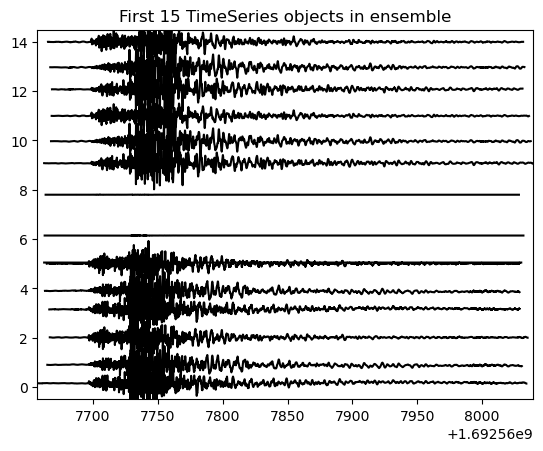

In [11]:
from mspasspy.graphics import SeismicPlotter
from mspasspy.ccore.seismic import TimeSeriesEnsemble
plotter = SeismicPlotter(normalize=True)
# these are just to improve the plot
plotter.style="wt"
plotter.title="First 15 TimeSeries objects in ensemble"
e2plot=TimeSeriesEnsemble(15)
for i in range(15):
    e2plot.member.append(ensemble.member[i])
e2plot.set_live()
plotter.plot(e2plot)

### Disucssion

Before moving on if I'd like to try a brief discussion of a few issues here:

- How would you set up a data management scheme for SCEDC event data where you would only pull waveform data for processing as you needed it?
- I know from experience (we could test it) that reading similar sized ensembles from a local disk stored as native MsPASS objects takes around one second.  How would that effect your design?
- How would you parallelize event processing with this model?   How might that impact your decision for local versus remote storage?
text should then move a discussion of what one might do next with that capability?  
- The miniseed data has not source and receiver metadata.   What would be the MsPASS way to handle that issue?

## Continuous data
The final issue I want to address in this tutorial is handling of continuous data.  Note there are two common applications where accessing the continuous data is necessary:
1.  Ambient noise processing by cross-correlation.
2.  Extracting teleseismic event segments.  No US regional networks routinely process and create event files from teleseismic events so the only way to do so is to carve what you want from continuous data.  Earthscope will have this option as well, but they will likely supply an event extraction service.

The requirements of the first are very different from the second.  There all the samples in a day file are required while for the telseismic case, which is what we do here, we only need a small fraction of a day's data.   We will discuss the implications of that at the end of this session.

As we saw above SCEDC uses the current standard model of "day files" to store one channel of data for each recording day.  As a result, the algorithm below loops over all single channel waveform files carvng out a fix one hour window starting 100 s after the origin time of the Tohoku earthquake.  It then accumulates the windowed waveform data in a `TimeSeriesEnsemble` it then saves at the end of the code box.  

First, we need to specify the time period.   For this tutorial we do that as a hand job using an estimate from and outside source.  

In [12]:
from obspy import UTCDateTime
origin_time=UTCDateTime("2011-03-11T05:46:23.200000Z")
print("Event origin time=",origin_time)
# Define window range like test data as +100 s to +3700 s
tstart = origin_time.timestamp + 100.0
tend = origin_time.timestamp + 3700.0
print("Julian day of event=",origin_time.julday)

Event origin time= 2011-03-11T05:46:23.200000Z
Julian day of event= 70


Next we run the fetch and window algorithm.   This box will run for several minutes.  Start this next box and while it is running we will discuss the following issues:

-  Do you have a feel for the time required for this trivial processing?  What is your leading hypothesis for the limiting step in this process?
-  As a comparison this exact same job ran on my little linux PC development system (a generic 5 year old intel PC running Ubuntu) with a home modest internet connection took 2328 s (about 40 m) to run.  We'll know soon what you get, but we should be able to get a ballpark estimate of GeoLab by comparison.  What is the significance of those numbers?
-  If we have time I can show you results form our paper in press at SRL on this topic.   This test reinforces a key conclusion of that paper. 


In [13]:
from mspasspy.algorithms.window import WindowData
# timing the process time here is an important less
import time
t0=time.time()
# fetch the index for 2011_070
collection="SCEDC_s3_index"
# type qualifier isn't needed because catalog data do not have year and day attributes
query={"year" : origin_time.year, "day" : origin_time.julday,"format" : "parquet"}
index_doc=db[wfindex_collection].find_one(query)
index_docs = scedc.make_day_index(index_doc)
print("Number of day files in index for this day=",len(index_docs))
# directory and file name where data are stored
dir="wf_TimeSeries/tohoku"
dfile="SCEDCwfdata.binary"
ndoc= 0
for doc in index_docs:
    ens = scedc.s3_mseed_reader(doc)
    # because we set the reader to segment a file if it contains a gap, the return 
    # of this function is an ensemble.  We have to loop over the ensemble members 
    # to save all the data if the gap is inside the segment
    if ens is not None:
        for d in ens.member:
            d["dir"]=dir
            d["dfile"]=dfile
            d["storage_mode"]="file"
            d = WindowData(d,tstart,tend)
            # note a segment with no data in the tstart to tend range will be marked dead
            # by WindowData.  Here we let the database writer bury those segments in 
            # the cemetery.  We could just drop them but that preserves a record of what 
            # stations had the gaps of we wanted to pursue that
            db.save_data(d,collection="wf_TimeSeries",storage_mode="file",data_tag="tohoku")
    ndoc += 1
    if ndoc%250 == 0:
        print("Finished process ",ndoc," waveforms")
t=time.time()
print("Time to process ",len(index_docs)," day files stored on s3=",t-t0)
print("Time per channel processed=",(t-t0)/len(index_docs))

Number of day files in index for this day= 1751
Warning - object content was a data gap and was segmented
Number of segments= 2
Warning - object content was a data gap and was segmented
Number of segments= 2
Warning - object content was a data gap and was segmented
Number of segments= 2
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCCBX__HHE___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCCBX__HHN___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCCBX__HHZ___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCSPX__HHE___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCSPX__HHN___2011070.ms
The s3 client say the specified 

Finally, count how many waveforms were saved and plot data from one randomly selected station.

In [3]:
print("Number of TimeSeries data saved=",db.wf_TimeSeries.count_documents({}))

Number of TimeSeries data saved= 1715


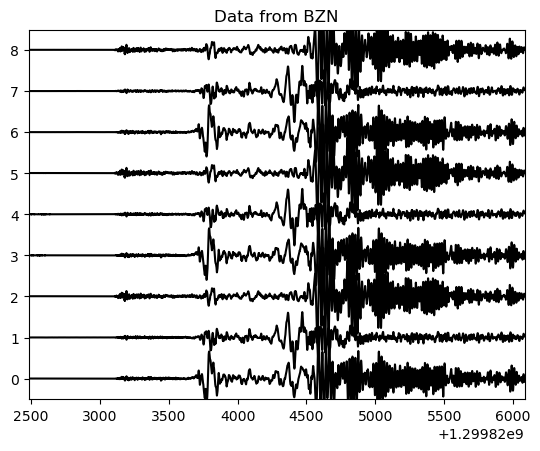

In [6]:
query={"sta" : "BZN"}  # first station in the file - random choice
cursor=db.wf_TimeSeries.find(query)
e = db.read_data(cursor,collection="wf_TimeSeries")
plotter.title="Data from BZN"
plotter.plot(e)